In [1]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---

- ## 샘플만으로 Median 값 추정

In [2]:
births = Table.read_table("./csv/baby.csv")
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


- ### 출생 체중과 임신 일수의 비율을 포함한 테이블 생성

In [7]:
ratios = births.select("Birth Weight", "Gestational Days").with_column(
    "Ratio BW:GD", births.column("Birth Weight") / births.column("Gestational Days")
)
ratios.show(3)

Birth Weight,Gestational Days,Ratio BW:GD
120,284,0.422535
113,282,0.400709
128,279,0.458781


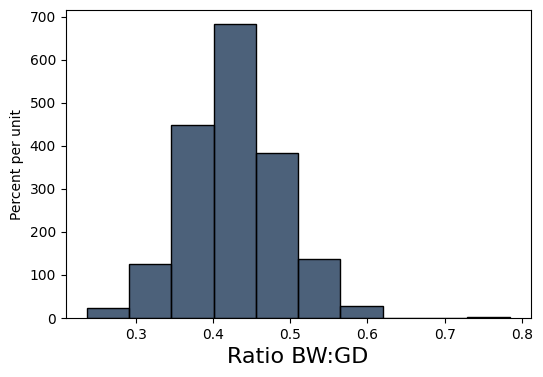

In [8]:
ratios.select("Ratio BW:GD").hist()

- ### 비율의 일부는 상당히 크므로 중앙값을 사용하는 것이 좋음
    - #### 평균은 특이점에 의해 영향을 받음

- ### 표본의 중앙값

In [10]:
percentile(50, ratios.column("Ratio BW:GD"))

0.42907801418439717

<br>

- ### 모집단의 중앙값은 알 수 없으므로, bootstrap을 이용하여 모집단의 중앙값 구하기
    - #### 중복 허용하는 표본과 같은 크기의 샘플 생성하여 중앙값 구하기

In [13]:
def one_bootstrap_median():
    resample = ratios.sample()
    return percentile(50, resample.column("Ratio BW:GD"))

num_repetitions = 5000
bstrap_medians = make_array()
for _ in range(num_repetitions):
    bstrap_medians = np.append(bstrap_medians, one_bootstrap_median())
bstrap_medians

array([ 0.42916667,  0.42750929,  0.42910448, ...,  0.42907801,
        0.43129771,  0.43014706])

- ### 신뢰구간 95%의 양 끝값 추출
    - #### 양쪽 끝 합 5% 이므로 양 끝 2.5%

In [16]:
left = percentile(2.5, bstrap_medians)
right = percentile(97.5, bstrap_medians)
left, right

(0.42545454545454547, 0.43262411347517732)

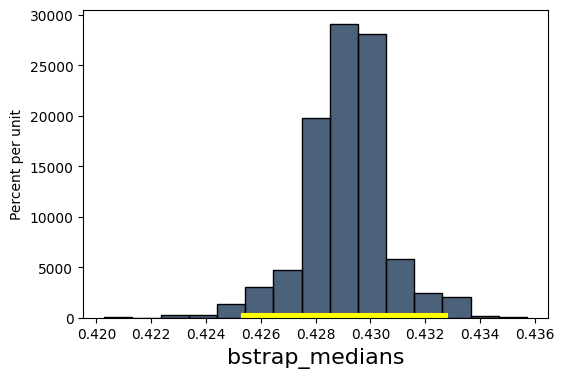

In [18]:
Table().with_column("bstrap_medians", bstrap_medians).hist(bins=15)
plt.plot([left, right], [0, 0], color="yellow", lw=8)

<br>

- ### Bootstrap으로 모집단의 산모들의 평균 연령을 추정

In [24]:
def one_bootstrap_avg():
    samp = births.sample()
    return np.average(samp.column("Maternal Age"))

num_repetitions = 5000
bstrap_averages = make_array()
for _ in range(num_repetitions):
    bstrap_averages = np.append(bstrap_averages, one_bootstrap_avg())
bstrap_averages

array([ 26.94463373,  27.06643952,  27.01022147, ...,  27.30494037,
        27.17546848,  27.08432709])

- ### 신뢰구간 95%일 때 양 끝값 추출

In [28]:
left = percentile(2.5, bstrap_averages)
right = percentile(97.5, bstrap_averages)
left, right

(26.897785349233391, 27.557069846678022)

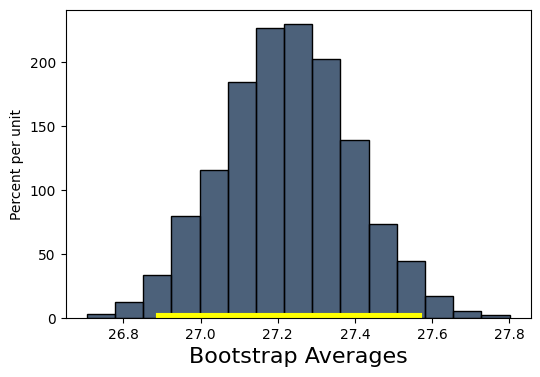

In [29]:
Table().with_column("Bootstrap Averages", bstrap_averages).hist(bins=15)
plt.plot([left, right], [0, 0], color="yellow", lw=8)

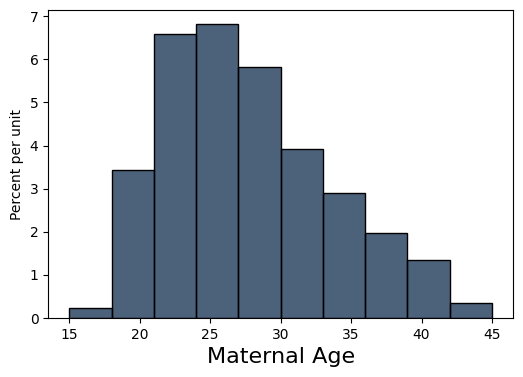

In [19]:
births.select("Maternal Age").hist()

- ### 모집단의 평균 나이 히스토그램은 대칭이 아니었지만, 샘플의 평균 나이 히스토그램은 좌우 대칭임

---

- ## 호지킨 병 치료에 대한 샘플 데이터

In [31]:
hodgkins = Table.read_table("./csv/hodgkins.csv")
hodgkins.show(3)

height,rad,chemo,base,month15
164,679,180,160.57,87.77
168,311,180,98.24,67.62
173,388,239,129.04,133.33


- ### 15개월 경과 후 대부분 폐 건강이 나빠졌음

In [32]:
hodgkins = hodgkins.with_column("Drop", hodgkins.column("base") - hodgkins.column("month15"))
hodgkins

height,rad,chemo,base,month15,Drop
164,679,180,160.57,87.77,72.8
168,311,180,98.24,67.62,30.62
173,388,239,129.04,133.33,-4.29
157,370,168,85.41,81.28,4.13
160,468,151,67.94,79.26,-11.32
170,341,96,150.51,80.97,69.54
163,453,134,129.88,69.24,60.64
175,529,264,87.45,56.48,30.97
185,392,240,149.84,106.99,42.85
178,479,216,92.24,73.43,18.81


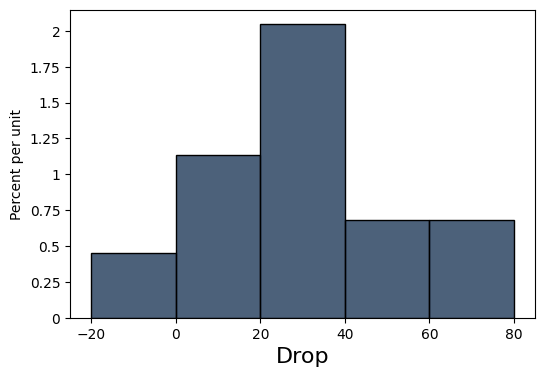

In [33]:
hodgkins.select("Drop").hist(bins=np.arange(-20, 81, 20))

- ### 샘플의 평균 하락폭은 28.6

In [35]:
np.average(hodgkins.column("Drop"))

28.615909090909096

<br>

- ## 가설
    - ### 귀무 가설: 우연에 의한 변동임, 모집단에서의 평균 감소는 0
    - ### 대립 가설: 우연이 아님, 모집단에서도 평균 감소 존재

<br>

- ### bootstrap을 통해 모집단에서의 평균 감소 확인

In [36]:
def one_bootstrap_mean():
    samp = hodgkins.sample()
    return np.mean(samp.column("Drop"))

num_repetitions = 10000
bstrap_means = make_array()
for _ in range(num_repetitions):
    bstrap_means = np.append(bstrap_means, one_bootstrap_mean())
bstrap_means

array([ 31.10590909,  32.36      ,  27.36136364, ...,  31.07545455,
        24.71      ,  27.69363636])

- ### 99% 신뢰구간의 양 끝

In [38]:
left = percentile(0.5, bstrap_means)
right = percentile(99.5, bstrap_means)
left, right

(17.271818181818183, 40.217272727272729)

- #### 신뢰구간에 0이 포함되지 않으므로 귀무가설 기각